<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [17]:
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class G:
    ITERATIONS = 100
    DURATIONS = 6120
    fac_id_df = pd.read_excel("data/FacilityIDLookup.xlsx")
    priv_df = pd.read_excel("data/Privileges.xlsx")
    proc_id_df = pd.read_excel("data/ProcedureIDLookup.xlsx")
    rad_sched_df = pd.read_excel("data/RadiologistSchedules.xlsx")
    restr_df = pd.read_excel("data/Restrictions.xlsx")

In [4]:
def process_data():
    G.rads_list = sorted(G.rad_sched_df["RadiologistID"].unique())
    rads_in_priv = sorted(G.priv_df["RadiologistID"].unique())
    red_priv_df = G.priv_df[G.priv_df["RadiologistID"].isin(G.rads_list)]
    G.radiologist_ids = list(set(rads_in_priv).intersection(set(G.rads_list)))
    G.red_rad_sched_df = G.rad_sched_df[G.rad_sched_df["RadiologistID"].isin(G.radiologist_ids)]
    G.facilities = sorted(red_priv_df["FacilityID"].unique())
    G.procedures_list = sorted(G.proc_id_df["ProcedureID"].unique())
    G.modalities = list(G.proc_id_df.Modality.unique())
    start_time = G.rad_sched_df["Start Time"][0]
    G.rad_sched_df['Relative Start Time'] = (G.rad_sched_df["Start Time"] - start_time)/np.timedelta64(1, 's')/60
    G.rad_sched_df['Relative End Time'] = (G.rad_sched_df["End Time"] - start_time)/np.timedelta64(1, 's')/60
    G.radiologists_by_fac = G.priv_df.groupby("FacilityID")["RadiologistID"].apply(list).reset_index(name='Radiologists').set_index("FacilityID")
    G.facilities_by_rad = G.priv_df.groupby("RadiologistID")["FacilityID"].apply(list).reset_index(name='Facilities').set_index("RadiologistID")

In [5]:
process_data()

In [6]:
G.target_times = {
    1: 10,
    2: 20,
    3: 60
}

G.specialties = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}

In [84]:
class MedicalImage(object):    
    def __init__(self, img_id, time_created, urgency, image_type):#, modality, speciality, urgency, image_label):
        self.img_id = img_id
        self.time_created = time_created
        self.urgency = urgency
        self.image_type = image_type
        self.target_time = G.target_times[urgency]
        self.time_remaining = G.target_times[urgency]
        self.in_queues = []   #keep track on which queues image is in [rad_id, position]
        self.time_seen = 0
        self.time_done = 0
        self.rad_seen = "None"
        
    def update_time_remaining(self, t):
        self.time_remaining = self.target_time - (t - self.time_created)
        
        
class Radiologist:
    def __init__(self, rad_id, specialties, working=True):
        self.queue = []
        self.rad_id = rad_id
        self.specialties = specialties
        self.is_working = working
        self.images_served = []
        self.idle_times = []
        self.time_of_last_idle = 0
        self.time_last_not_idle = 0
        self.busy_times = []
        self.time = 0
        self.time_of_step = 0
        self.queue_length = []
        self.service_starts = []
        self.service_ends = []
        self.service_time = []
        
    def get_stats(self):
        return self.idle_times, self.busy_times, self.queue_length, self.service_starts, self.service_ends, self.service_time 
        
    def show_queue(self):
        return self.queue
    
    def add_job(self, med_image, time):
        self.queue.append(med_image)    #each customer is represented by the time it will take for them to be served
        #print(self.show_queue())
        
    def update_queue(self, time):
        for img in self.queue:
            img.update_time_remaining(time)
        #sort_queue()        
    #def sort_queue(self):
               
    def update(self, time, add_cust_bool=False):
        self.time_of_step =  time - self.time
        self.update_queue(time)
        if add_cust_bool:
            self.add_customer(time)
        self.show_queue()
        self.queue_length.append(len(self.queue.elements))
        self.time = time      
        
        
class SystemState:
    def __init__(self, events, images, rads):
        self.time = 0
        self.events = events
        self.images = images
        self.rads = rads
        self.rads_working = rads
        self.rads_not_working = []
        self.events_history = []
        self.queue_lengths = []
        self.time_steps = []
        
    def create_event(self, time, event_type, obj):
        self.events.append([time, event_type, obj])
        self.events = sorted(self.events, key=lambda x: x[0])
        
    def process_event(self):
        event = self.events[0]
        self.events_history.append(event)
        self.time = event[0]       
        event_type = event[1]
        del self.events[0]
        temp_list = []
        for r in self.rads:
            temp_list.append(len(r.queue))
        self.queue_lengths.append(temp_list)
        self.time_steps.append(self.time)
            
        if event_type == "New Job":
            self.distribute_job(event[2])
        elif event_type == "Job Done":
            rad = event[2]
            self.complete_job(rad)
        print("Event processed")
        if len(self.events) > 0:
            self.process_event()
        else:
            print("Simulation complete")
                
    def distribute_job(self, med_image):
        urgency = med_image.urgency
        image_type = med_image.image_type
        capable_rads = []
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if image_type in rad.specialties:
                capable_rads.append(rad)
        for rad in capable_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues() 
        
    def update_queues(self):
        for rad in self.rads_working:
            rad.update_queue(self.time)
                
    def start_job(self, rad):
        med_image = rad.queue[0]
        image_type = med_image.image_type
        urgency = med_image.urgency
        rad.service_starts = self.time
        med_image.time_seen = self.time
        med_image.rad_seen = rad.rad_id
        self.events_history.append([self.time, "Job Started", med_image])
        process_time = np.random.exponential(G.target_times[urgency])
        self.create_event(self.time+process_time, "Job Done", rad)
        print(f"Image {med_image.img_id} is seen by radiologist {rad.rad_id} at {self.time}")
        for r in med_image.in_queues:
            if r != rad:
                r.queue.remove(med_image)           
        
    def complete_job(self, rad):
        med_image = rad.queue[0]
        rad.images_served.append(med_image.img_id)
        rad.service_ends.append(self.time)
        med_image.time_done = self.time
        print(f"Image {med_image.img_id} is done by radiologist {rad.rad_id} at {self.time}")
        del rad.queue[0]
        if len(rad.queue) > 0:
            self.start_job(rad)
        
    def run_simulation(self):
        self.process_event()
        

def sim(duration, image_freq, num_rads):
    arrival_times = []
    time = 0
    while time < duration*60 :
        time += np.random.exponential(image_freq)
        arrival_times.append(time)        
    med_images = []
    for i, t in enumerate(arrival_times):
        med_images.append(MedicalImage(i, t, random.sample(list(G.target_times.keys()), 1)[0], random.sample(list(G.specialties.keys()), 1)[0]))       
    radiologists = []
    for i in range(num_rads):
        specialties_temp = random.sample(list(G.specialties.keys()), random.randrange(2,6))
        radiologists.append(Radiologist(i, specialties_temp))       
    events=[]
    for img in med_images:
        events.append([img.time_created, 'New Job', img])        
    s = SystemState(events, med_images, radiologists)
    s.run_simulation()    
    return s


def plot_queue_lengths(s):
    fig, ax = plt.subplots()
    for i in range(len(s.queue_lengths[0])):
        plt.plot(s.time_steps, [item[i] for item in s.queue_lengths])
        
        
def plt_mean_queue_length(s_list):
    fig, ax = plt.subplots()
    for s in s_list:
        plt.plot(s.time_steps, pd.DataFrame(s.queue_lengths).sum(axis=1))
    plt.xlabel("time")
    plt.ylabel("Mean Queue Length")
    plt.show()

In [85]:
s1 = sim(3, 2, 10)

Image 0 is seen by radiologist 0 at 1.39709868870003
Event processed
Image 1 is seen by radiologist 1 at 1.7361808973234238
Event processed
Image 2 is seen by radiologist 4 at 1.920577753261862
Event processed
Image 3 is seen by radiologist 6 at 1.9364952073241348
Event processed
Image 4 is seen by radiologist 2 at 2.7855001588375012
Event processed
Image 5 is seen by radiologist 7 at 11.93257179396969
Event processed
Image 1 is done by radiologist 1 at 12.21604639600635
Event processed
Image 3 is done by radiologist 6 at 12.433043266839015
Event processed
Image 6 is seen by radiologist 1 at 13.781297651416144
Event processed
Image 7 is seen by radiologist 6 at 13.805882643249769
Event processed
Image 8 is seen by radiologist 3 at 14.392357454684051
Event processed
Image 9 is seen by radiologist 5 at 14.861179075167247
Event processed
Image 9 is done by radiologist 5 at 16.227866228655497
Event processed
Image 8 is done by radiologist 3 at 16.415326879003985
Event processed
Image 7 is 

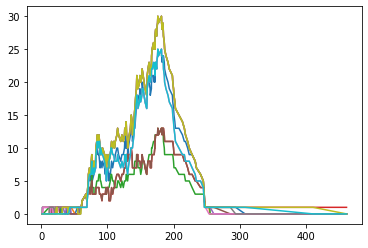

In [86]:
plot_queue_lengths(s1)

In [87]:
s_list = []
for i in range(5,15):
    s_list.append(sim(3, 10, i))

Image 0 is seen by radiologist 0 at 7.703822048106479
Event processed
Image 1 is seen by radiologist 1 at 23.207060961156706
Event processed
Image 2 is seen by radiologist 3 at 25.016661667058443
Event processed
Image 0 is done by radiologist 0 at 26.364430135041907
Event processed
Image 2 is done by radiologist 3 at 29.78171102191689
Event processed
Image 3 is seen by radiologist 0 at 40.96966566701483
Event processed
Image 4 is seen by radiologist 3 at 45.956835618907974
Event processed
Image 5 is seen by radiologist 4 at 47.09292798565545
Event processed
Event processed
Image 7 is seen by radiologist 2 at 58.61242247552529
Event processed
Event processed
Image 1 is done by radiologist 1 at 71.67670683216494
Image 6 is seen by radiologist 1 at 71.67670683216494
Event processed
Event processed
Image 6 is done by radiologist 1 at 80.74165833640613
Image 8 is seen by radiologist 1 at 80.74165833640613
Event processed
Image 7 is done by radiologist 2 at 82.0893760421834
Event processed
I

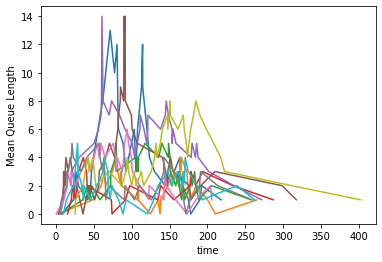

In [88]:
plt_mean_queue_length(s_list)

In [91]:
s.images[0].time_seen

2.436269696557877

In [92]:
s.images[0].time_done

6.885088883339574

In [96]:
s.rads[0]